### Homework 04

Name: Yining Liu  
Github Username: Lynzz1701    
USC ID: 6168529797 

#### preprocessing from HW3

In [8]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import statsmodels.api as sm

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
AReM = '../data/AReM'
activities = os.listdir(AReM)
activities.sort()
idx = 1

for activity in activities:
    if (os.path.splitext(activity)[1] == '') and (activity != '.DS_Store'):
        instances = os.listdir(os.path.join(AReM,activity))
        instances.sort(key = lambda x:int(x.split('.')[0].split('set')[1]))
        
        for csv in instances:
            df_tmp = pd.read_csv(os.path.join(AReM,activity,csv), skiprows = 5,
                            names=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])
            df_tmp['activity'] = activity
            df_tmp['instance'] = idx
            idx += 1
            #if df_tmp.shape[0] != 480:
                #print(idx)
            if csv == instances[0] and activity == 'bending1':
                df = df_tmp
            else:
                df = pd.concat([df,df_tmp])

df
#os.makedirs('../data', exist_ok=True)  
#df.to_csv('../data/out.csv') 

#df_mul = df.set_index(['activity','instance'])
#df_mul
#df_mul.loc['bending1'].loc[2]

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity,instance
0,0,39.25,0.43,22.75,0.43,33.75,1.30,bending1,1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,bending1,1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,bending1,1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,bending1,1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,bending1,1
...,...,...,...,...,...,...,...,...,...
475,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking,88
476,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking,88
477,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking,88
478,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking,88


In [10]:
df_idx = df
df_idx = df_idx.set_index('instance')
test_list = [1,2,8,9,14,15,16,29,30,31,44,45,46,59,60,61,74,75,76]
train_list = [i for i in range(1,89) if i not in test_list]

#19 test instances 9,120 rows
test_data = df_idx.loc[test_list]

#69 test instances 33,119 rows
train_data = df_idx.loc[train_list]

In [11]:
#part2 - normalized preprecessing

#axis = 1 to normalize each feature
df_idx_norm_array = preprocessing.normalize(df.iloc[:,1:7],axis=1)
df_idx_norm = df

for i in range(42239):
    for j in range(1,7):
        df_idx_norm.iat[i,j] = df_idx_norm_array[i][j-1]

        #part2 - normalized
df_idx_norm = df_idx_norm.set_index('instance')

info_df_norm = pd.DataFrame(columns = ['min_1','max_1','mean_1','median_1','std_1','1st_quart_1','3rd_quart_1',
                                 'min_2','max_2','mean_2','median_2','std_2','1st_quart_2','3rd_quart_2',
                                 'min_3','max_3','mean_3','median_3','std_3','1st_quart_3','3rd_quart_3',
                                 'min_4','max_4','mean_4','median_4','std_4','1st_quart_4','3rd_quart_4',
                                 'min_5','max_5','mean_5','median_5','std_5','1st_quart_5','3rd_quart_5',
                                 'min_6','max_6','mean_6','median_6','std_6','1st_quart_6','3rd_quart_6',])

for i in range(1,89):
    row_tmp_norm = []
    for j in range(1,7):
        slice_tmp_norm = [df_idx_norm.loc[i].iloc[:,j].min(), df_idx_norm.loc[i].iloc[:,j].max(),
                          df_idx_norm.loc[i].iloc[:,j].mean(), df_idx_norm.loc[i].iloc[:,j].median(), 
                          df_idx_norm.loc[i].iloc[:,j].std(), 
                          df_idx_norm.loc[i].iloc[:,j].quantile(.25),df_idx_norm.loc[i].iloc[:,j].quantile(.75)]
        row_tmp_norm.extend(slice_tmp_norm)
    info_df_norm.loc[i] = row_tmp_norm
    
info_df_norm

,min_1,max_1,mean_1,median_1,std_1,1st_quart_1,3rd_quart_1,min_2,max_2,mean_2,...,std_5,1st_quart_5,3rd_quart_5,min_6,max_6,mean_6,median_6,std_6,1st_quart_6,3rd_quart_6
1,0.641312,0.784123,0.716733,0.719763,0.029022,0.698780,0.738124,0.0,0.022696,0.006362,...,0.037840,0.592935,0.633103,0.000000,0.035518,0.010025,0.007799,0.010269,0.000000,0.021856
2,0.661738,0.811324,0.740397,0.734299,0.026186,0.721188,0.757747,0.0,0.022132,0.006481,...,0.030199,0.553784,0.591471,0.000000,0.058461,0.009887,0.007728,0.010416,0.000000,0.022065
3,0.642306,0.806053,0.723129,0.723015,0.018166,0.713118,0.733099,0.0,0.030510,0.007103,...,0.023590,0.575935,0.602612,0.000000,0.029520,0.007997,0.007471,0.008291,0.000000,0.015105
4,0.615210,0.824067,0.722142,0.724013,0.038095,0.707361,0.747106,0.0,0.060758,0.012340,...,0.038526,0.552910,0.597576,0.000000,0.050670,0.010487,0.008536,0.009007,0.000000,0.016688
5,0.684126,0.825041,0.761174,0.760616,0.024758,0.747847,0.775718,0.0,0.054325,0.010023,...,0.024835,0.525497,0.559257,0.000000,0.033605,0.007023,0.007811,0.007073,0.000000,0.009541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.608216,0.925236,0.813489,0.823330,0.053329,0.778527,0.851437,0.0,0.410201,0.112478,...,0.083789,0.334087,0.441325,0.000000,0.224815,0.080068,0.074480,0.041604,0.048880,0.105096
85,0.639002,0.950316,0.822602,0.829697,0.053898,0.790097,0.863047,0.0,0.370272,0.109117,...,0.077204,0.321097,0.428155,0.000000,0.223197,0.083572,0.076356,0.043278,0.050225,0.112704
86,0.559898,0.932626,0.823830,0.831821,0.052931,0.799901,0.859427,0.0,0.350090,0.105997,...,0.076507,0.328761,0.425930,0.000000,0.243504,0.080623,0.074703,0.040977,0.051315,0.102598
87,0.662072,0.947159,0.823767,0.831901,0.050465,0.794635,0.859975,0.0,0.364251,0.105178,...,0.077952,0.326134,0.427311,0.000000,0.249944,0.081771,0.077991,0.041546,0.051312,0.105961


#### HW4 Preprocessing

In [12]:
original_features = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
df_train = (df_idx_norm.loc[train_list])[original_features]

#create label column for trainset
label_train = []
for i in range(9):
    label_train.append(1)
for i in range(60):
    label_train.append(0)

# break time series in trainset, l:1->20
# df_train_list[i]: broke into (i+1) pieces
df_train_list = []
for l in range(1,21):
    feature_df = pd.DataFrame(columns = list(range(1,6*7*l+1)))
    step = round(480/l)
    for i in train_list:
        row_tmp = []
        for j in range(l-1):
            for k in range(6):
                slice_tmp = [df_train.loc[i].iloc[j*step:(j+1)*step,k].min(), 
                             df_train.loc[i].iloc[j*step:(j+1)*step,k].max(),
                             df_train.loc[i].iloc[j*step:(j+1)*step,k].mean(), 
                             df_train.loc[i].iloc[j*step:(j+1)*step,k].median(),
                             df_train.loc[i].iloc[j*step:(j+1)*step,k].std(),
                             df_train.loc[i].iloc[j*step:(j+1)*step,k].quantile(.25),
                             df_train.loc[i].iloc[j*step:(j+1)*step,k].quantile(.75)]
                row_tmp.extend(slice_tmp)
        #last group edge cases
        for k in range(6):
            last_slice = [df_train.loc[i].iloc[(l-1)*step:,k].min(), 
                          df_train.loc[i].iloc[(l-1)*step:,k].max(),
                          df_train.loc[i].iloc[(l-1)*step:,k].mean(), 
                          df_train.loc[i].iloc[(l-1)*step:,k].median(),
                          df_train.loc[i].iloc[(l-1)*step:,k].std(),
                          df_train.loc[i].iloc[(l-1)*step:,k].quantile(.25),
                          df_train.loc[i].iloc[(l-1)*step:,k].quantile(.75)]
            row_tmp.extend(last_slice)
        feature_df.loc[i] = row_tmp
    feature_df['label'] = label_train
    df_train_list.append(feature_df)

#### 2(a)i Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

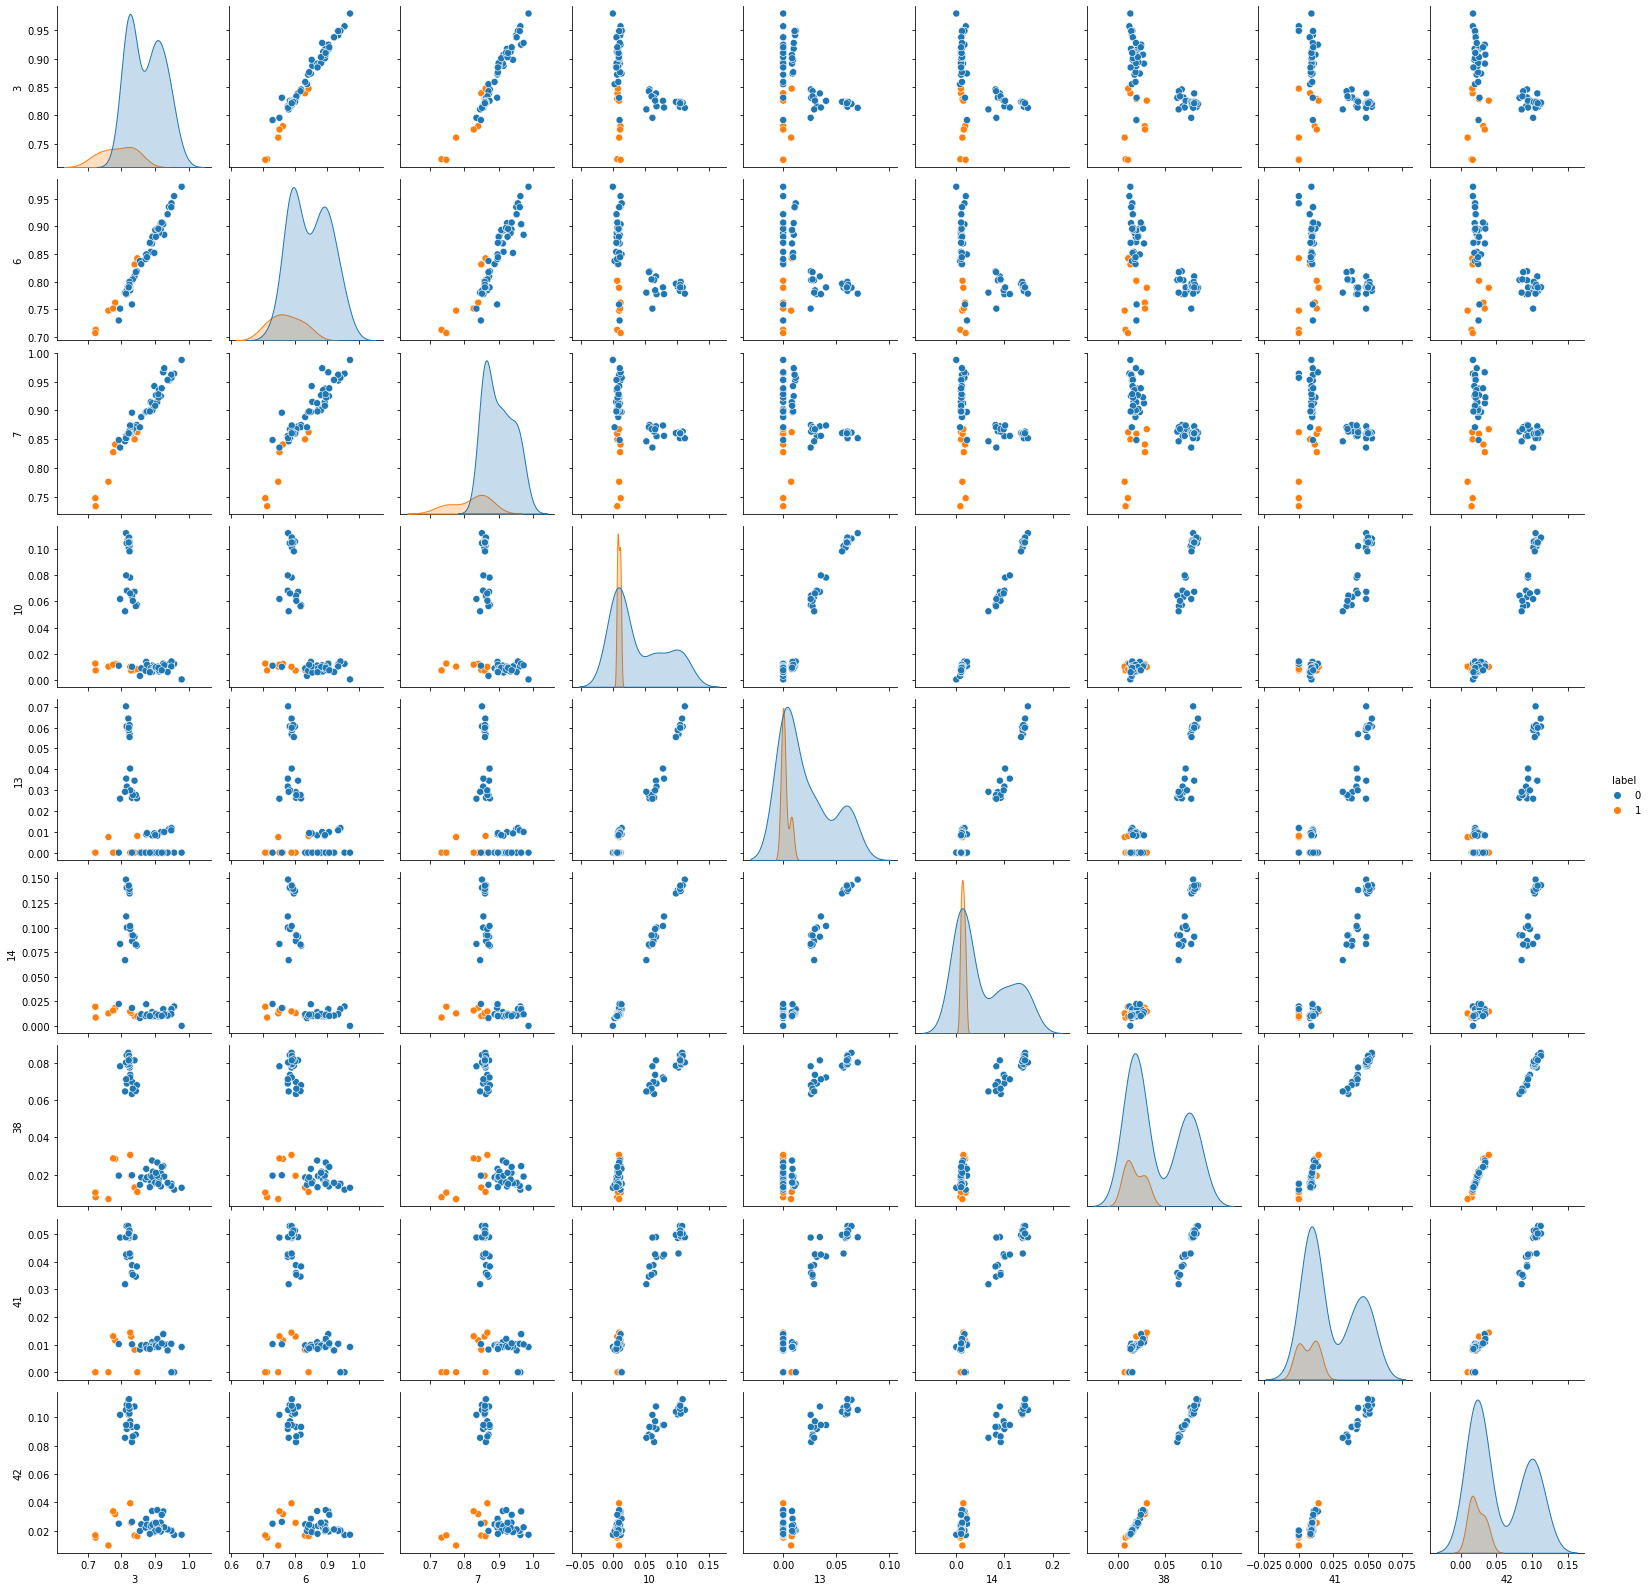

In [6]:
#(mean, 1st quart, 3rd quart) * (avg_rss12, var_rss12, var_rss23), normalized
#that is (3, 6, 7) * (1, 2, 6) 
'''
features = ['mean_1', '1st_quart_1', '3rd_quart_1',
           'mean_2', '1st_quart_2', '3rd_quart_2',
           'mean_6', '1st_quart_6', '3rd_quart_6']
'''
features = [3, 6, 7,
           10, 13, 14,
           38, 41, 42]

sns.pairplot(df_train_list[0], hue = 'label', vars=features, plot_kws={"s": 50})

#### 2(a)ii Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6.

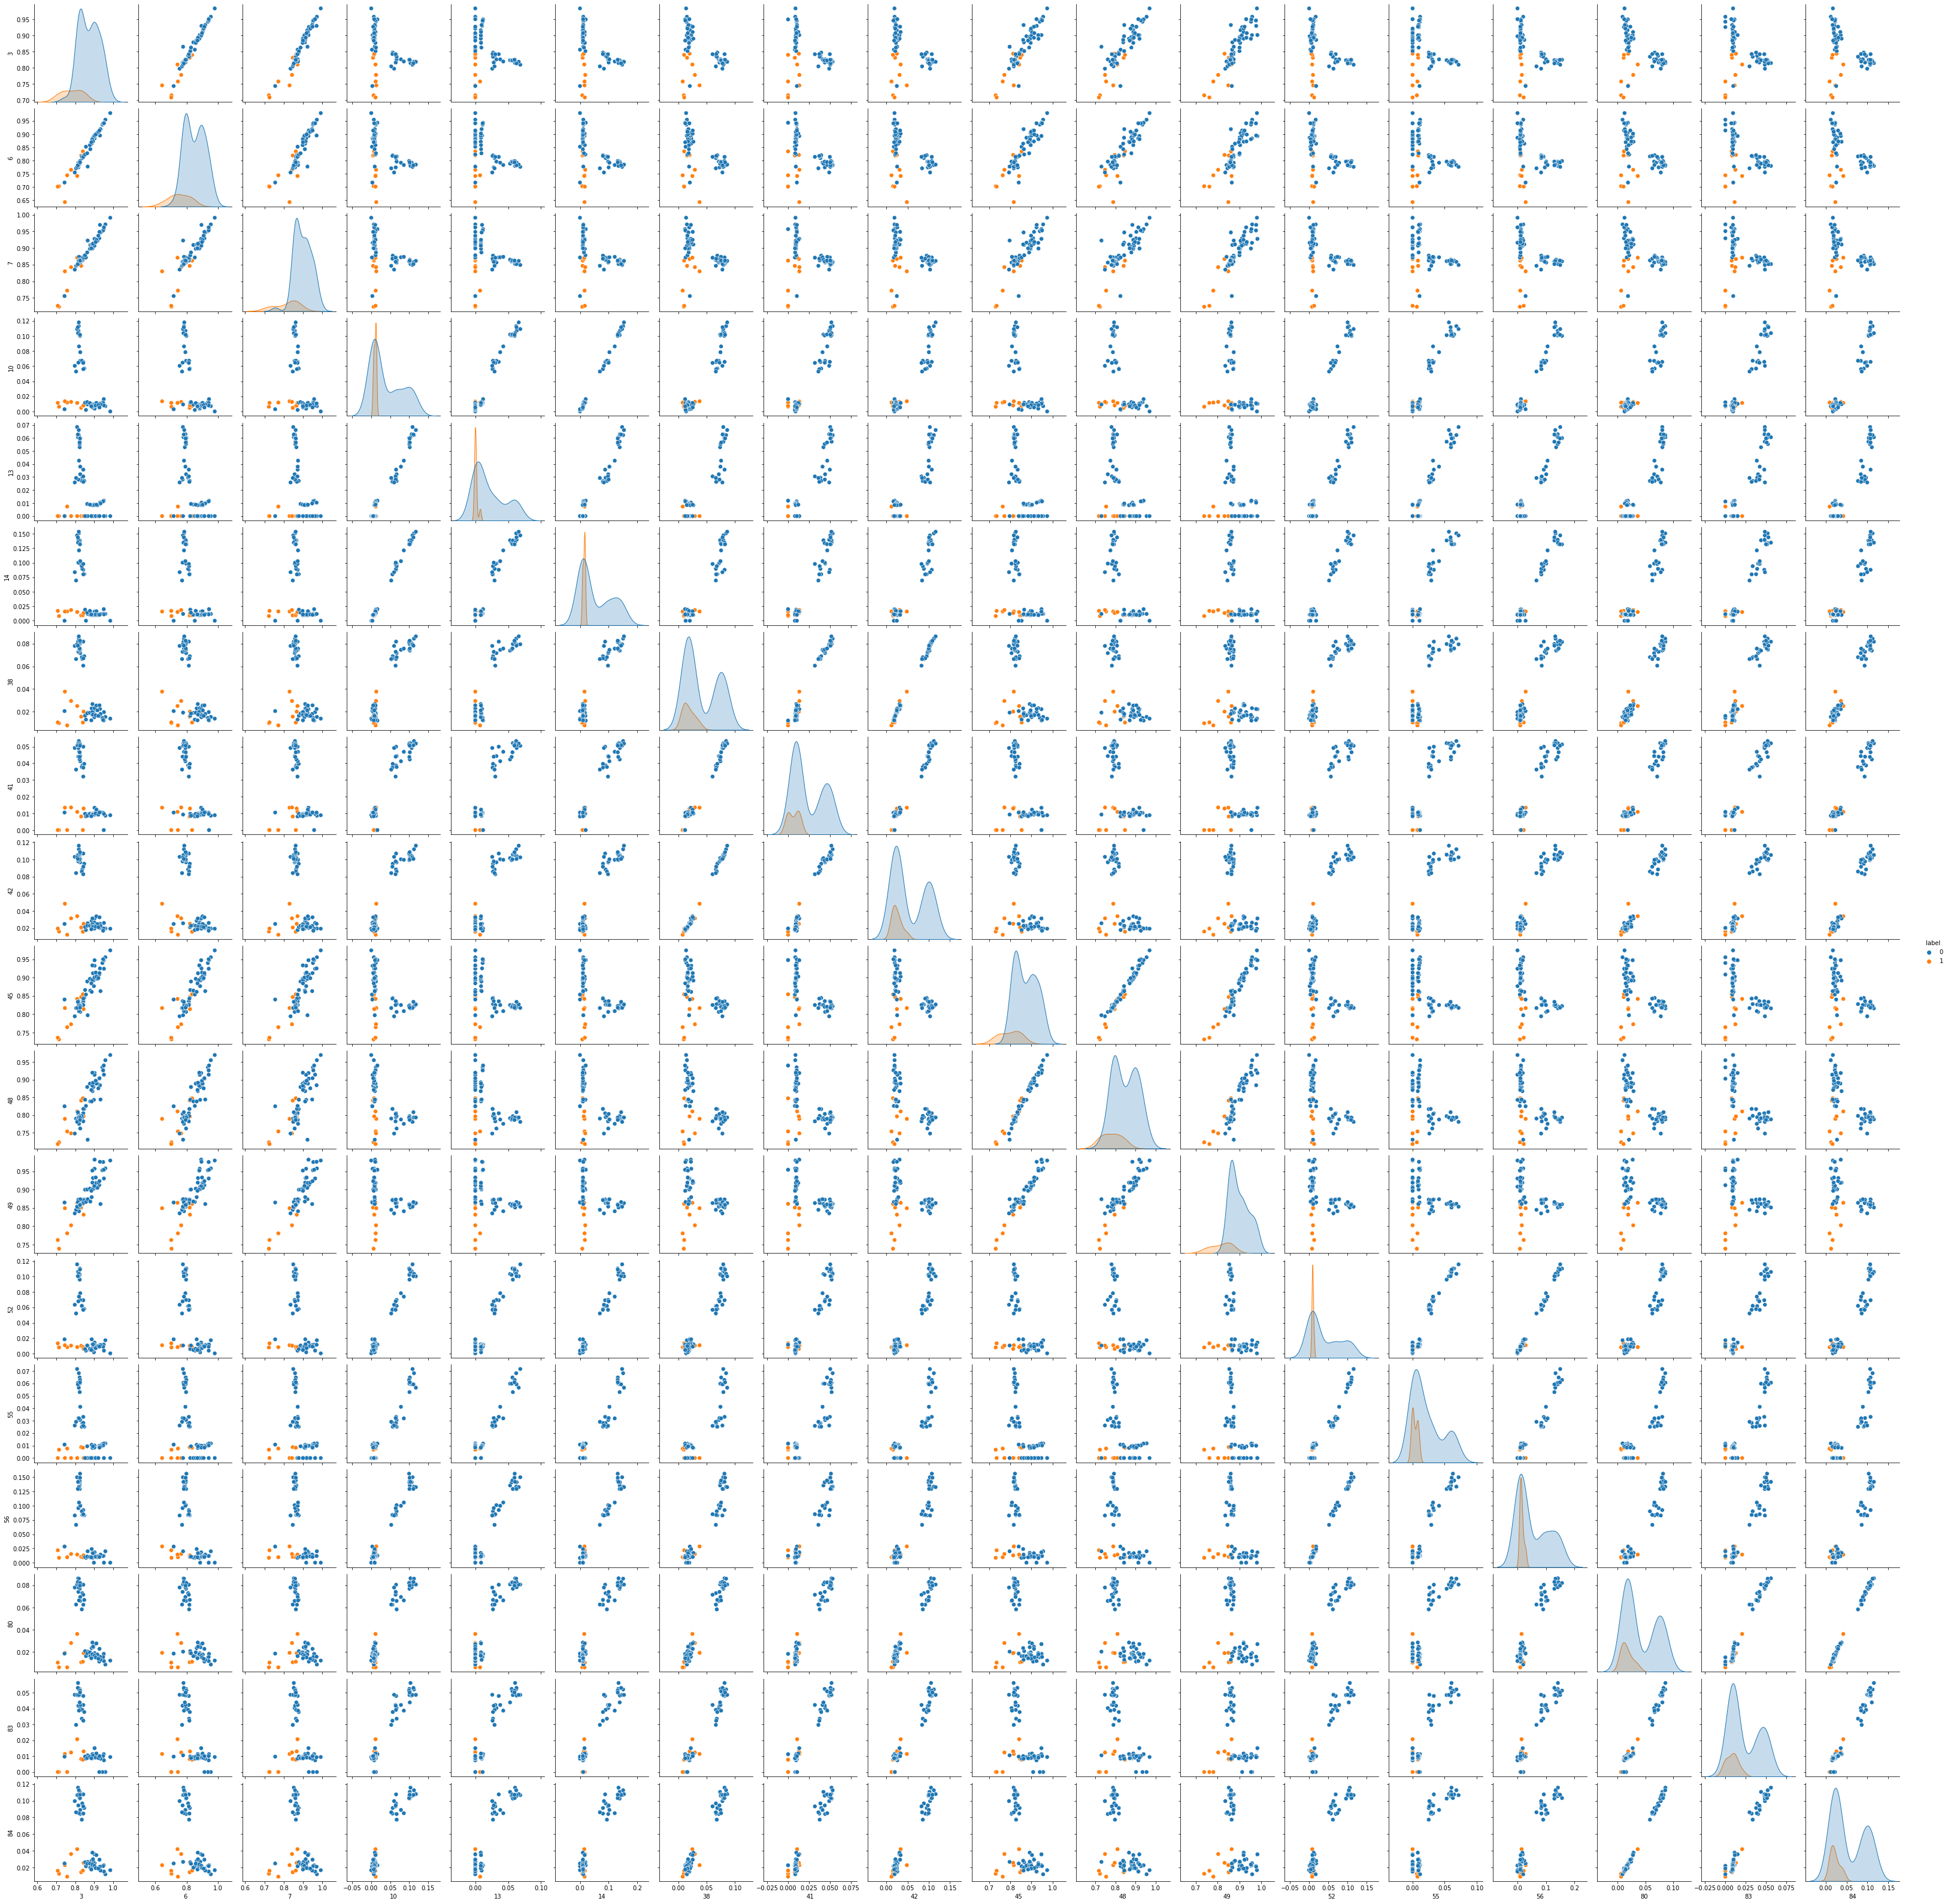

In [7]:
#(mean, 1st quart, 3rd quart) * (1, 2, 6, 7, 8, 12), in halves, normalized
#that is (3, 6, 7) * (1, 2, 6, 7, 8, 12) 
'''
features2 = ['mean_1', '1st_quart_1', '3rd_quart_1', 'mean_2', '1st_quart_2', '3rd_quart_2',
           'mean_6', '1st_quart_6', '3rd_quart_6', 'mean_7', '1st_quart_7', '3rd_quart_7',
           'mean_8', '1st_quart_8', '3rd_quart_8', 'mean_12', '1st_quart_12', '3rd_quart_12']
'''
features2 = [3, 6, 7, 
            10, 13, 14,
            38, 41, 42,
            45, 48, 49,
            52, 55, 56,
            80, 83, 84]

sns.pairplot(df_train_list[1], hue = 'label', vars=features2, plot_kws={"s": 50})

#### Do you see any considerable difference in the results with those of 2(a)i?

- the proportion of cells that "makes sense" (two classes are clearly separated or positive correlations can be seen) significantly increased.

#### 2(a)iii RFE + CV

- RFECV module from sklearn is used: to apply CV right on feature selection procedure (the right way)
- to avoid class imbalance: StratifiedKFold by default 

In [8]:
clf_list = []
for l in range(1, 21):
    features = []
    for i in range(l):
            features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i]
    
    X, y = df_train_list[l-1][features], df_train_list[l-1]['label']
    clf = LogisticRegression(random_state=13, C=float('inf'),n_jobs=-1, max_iter=10000)
    #StratifiedKFold by default 
    selector = RFECV(clf, step=1, cv=5)
    model = selector.fit(X, y)
    clf_list.append(model)

In [9]:
#lists of (l, p) pairs and their scores in cv
l_p_list = []
cv_score_list = []
for l in range(1,21):
    l_p_list.append((l, clf_list[l-1].n_features_))
    cv_score_list.append(clf_list[l-1].cv_results_['mean_test_score'].max())

lp_table = pd.DataFrame(columns = ['(l, p)', 'cv_score'])
lp_table['(l, p)'] = l_p_list
lp_table['cv_score'] = cv_score_list
    
#the best (l, p) and its corresponding cv score
print('the best score is', max(cv_score_list))
print('yielded when (l, p) =', l_p_list[cv_score_list.index(max(cv_score_list))])
lp_table

the best score is 0.9714285714285715
yielded when (l, p) = (4, 7)


,"(l, p)",cv_score
0,"(1, 2)",0.927473
1,"(2, 11)",0.941758
2,"(3, 14)",0.956044
3,"(4, 7)",0.971429
4,"(5, 15)",0.956044
5,"(6, 29)",0.957143
6,"(7, 33)",0.971429
7,"(8, 18)",0.941758
8,"(9, 42)",0.957143
9,"(10, 73)",0.971429


#### 2(a)iv Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

Confusion Matrix when l = 4:
[[60  0]
 [ 0  9]]


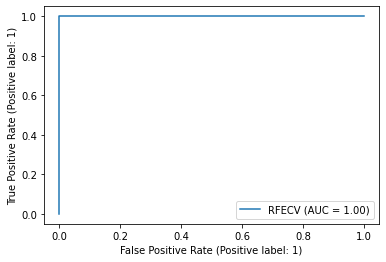

In [10]:
best_l = 4
best_model = clf_list[best_l-1]
features = []
for i in range(best_l):
            features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i] 
X_train, y_train = df_train_list[best_l-1][features], df_train_list[best_l-1]['label']

preds_train = best_model.predict(X_train)
CM = metrics.confusion_matrix(y_train, preds_train)
print('Confusion Matrix when l = 4:')
print(CM)

metrics.RocCurveDisplay.from_estimator(best_model, X_train, y_train)

sklearn dont do p-values and coefs. refit model using statsmodels with pruned features

In [11]:
features_index = [14,19,20,23,29,30,32]
features_pruned = []
for i in features_index:
    features_pruned.append(features[i])

X_train_alt, y_train_alt = df_train_list[best_l-1][features_pruned], df_train_list[best_l-1]['label']
#X_train_alt = sm.add_constant(X_train_alt)
reg = sm.Logit(y_train_alt, X_train_alt).fit(method='bfgs',maxiter=100000000)
reg.summary()

Optimization terminated successfully.
         Current function value: 0.267321
         Iterations: 136
         Function evaluations: 139
         Gradient evaluations: 139


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                  0.3096
Time:                        01:49:23   Log-Likelihood:                -18.445
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                   0.01111
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
56           -51.4887     65.604     -0.785      0.433    -180.071      77.093
90           -42.4108     26.093     -1.625      0.104     -93.553       8.731
91            30.7643     24.338      1.264      0.206     -16.938      78.467
98           -47.0533     92.023     -0.511      0.609    -227.415     133.309
133            8.8521     18.958      0.467      0.641     -28.304      46.008
136         -201.7987    202.027     -0.999      0.318    -597.764     194.167
140          193.6647    136.018      1.424      0.154     -72.926     460.255
==============================================================================
"""

#### 2(a)v Test the classifier on the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

- cross-validation accuracy is high enough while accuracy on the test set yields 1
- possible reason: the test set is too small

In [19]:
df_test = (df_idx_norm.loc[test_list])[original_features]

#create label column for testset
label_test = [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# break time series in testset, l:1->20
# df_test_list[i]: broke into (i+1) pieces
df_test_list = []
for l in range(1,21):
    feature_df = pd.DataFrame(columns = list(range(1,6*7*l+1)))
    step = round(480/l)
    for i in test_list:
        row_tmp = []
        for j in range(l-1):
            for k in range(6):
                slice_tmp = [df_test.loc[i].iloc[j*step:(j+1)*step,k].min(), 
                             df_test.loc[i].iloc[j*step:(j+1)*step,k].max(),
                             df_test.loc[i].iloc[j*step:(j+1)*step,k].mean(), 
                             df_test.loc[i].iloc[j*step:(j+1)*step,k].median(),
                             df_test.loc[i].iloc[j*step:(j+1)*step,k].std(),
                             df_test.loc[i].iloc[j*step:(j+1)*step,k].quantile(.25),
                             df_test.loc[i].iloc[j*step:(j+1)*step,k].quantile(.75)]
                row_tmp.extend(slice_tmp)
        #last group edge cases
        for k in range(6):
            last_slice = [df_test.loc[i].iloc[(l-1)*step:,k].min(), 
                          df_test.loc[i].iloc[(l-1)*step:,k].max(),
                          df_test.loc[i].iloc[(l-1)*step:,k].mean(), 
                          df_test.loc[i].iloc[(l-1)*step:,k].median(),
                          df_test.loc[i].iloc[(l-1)*step:,k].std(),
                          df_test.loc[i].iloc[(l-1)*step:,k].quantile(.25),
                          df_test.loc[i].iloc[(l-1)*step:,k].quantile(.75)]
            row_tmp.extend(last_slice)
        feature_df.loc[i] = row_tmp
    feature_df['label'] = label_test
    df_test_list.append(feature_df)

Confusion Matrix when l = 4:
[[15  0]
 [ 0  4]]
score =  1.0


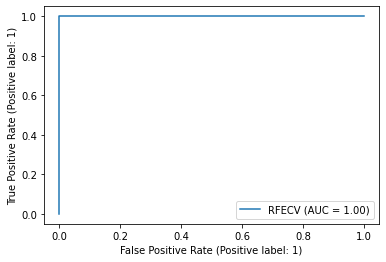

In [13]:
X_test = df_test_list[best_l-1][features] 
y_test = df_test_list[best_l-1]['label']
score_test = best_model.score(X_test,y_test)
preds_test = best_model.predict(X_test)
CM = metrics.confusion_matrix(y_test, preds_test)
print('Confusion Matrix when l = 4:')
print(CM)
print('score = ',score_test)

metrics.RocCurveDisplay.from_estimator(best_model, X_test, y_test)

#### 2(a)vi Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

- From the hint of previous pairplot it should've, since they indicated some linearly separable classes.
- However, not really while fitting, MaxIter was even set to 10000 to see what would happen.

#### 2(a)vii From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

- no imbalanced classes since StratifiedKFold is by default.

#### 2(b)i Repeat 2(a)iii using L1-penalized logistic regression.

- Cs set to 100
- liblinear used as solver

In [13]:
clf_l1_list = []
for l in range(1, 21):
    features = []
    for i in range(l):
            features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i]
    
    X, y = df_train_list[l-1][features], df_train_list[l-1]['label']
    
    #default Cs=10, chosen values in a logarithmic scale is not descriptive enough
    #different ls yields the same C=166
    #set Cs to 100
    clf_l1 = LogisticRegressionCV(Cs=100, cv=5, penalty='l1', solver='liblinear',
                                  random_state=13, n_jobs=-1, max_iter=10000)
    #StratifiedKFold by default 
    model = clf_l1.fit(X, y)
    clf_l1_list.append(model)

In [14]:
#lists of (l, c) pairs and their scores in cv
l_c_list = []
cv_score_l1_list = []
for l in range(1,21):
    l_c_list.append((l, clf_l1_list[l-1].C_[0]))
    cv_score_l1_list.append(clf_l1_list[l-1].scores_[1].mean(axis=0).max())

lc_table = pd.DataFrame(columns = ['(l, c)', 'cv_score_l1'])
lc_table['(l, c)'] = l_c_list
lc_table['cv_score_l1'] = cv_score_l1_list
    
#the best (l, c) and its corresponding cv score
print('the best score is', max(cv_score_l1_list))
print('yielded when (l, c) =', l_c_list[cv_score_l1_list.index(max(cv_score_l1_list))])
lc_table

the best score is 0.9571428571428571
yielded when (l, c) = (7, 242.01282647943833)


,"(l, c)",cv_score_l1
0,"(1, 79.24828983539186)",0.941758
1,"(2, 79.24828983539186)",0.941758
2,"(3, 79.24828983539186)",0.941758
3,"(4, 37.649358067924716)",0.942857
4,"(5, 45.34878508128591)",0.941758
5,"(6, 45.34878508128591)",0.942857
6,"(7, 242.01282647943833)",0.957143
7,"(8, 79.24828983539186)",0.942857
8,"(9, 21.544346900318867)",0.942857
9,"(10, 31.257158496882415)",0.942857


#### 2(b)ii Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

- RFECV(variable selection using p-values) performs better but L1-penalized is easier to implement.

#### 2(c)i Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.

- modify cv to 3-fold but bending2 has only 4 samples in training set. We dont want imbalanced classes.

In [15]:
#manually create multiclass labels
mul_label_test = [1,1,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7]
mul_label_train = [1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,
                  5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7]

In [16]:
mul_clf_l1_list = []
for l in range(1, 21):
    features = []
    for i in range(l):
            features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i]
    
    X, y = df_train_list[l-1][features], mul_label_train
    
    #set Cs to 100
    #class 2 i.e. bending2 has only 4 instances in trainset
    #use 3-fold cv instead of 5-fold i.e. cv=3
    mul_clf_l1 = LogisticRegressionCV(Cs=100, cv=3, penalty='l1', solver='saga',
                                  random_state=13, n_jobs=-1, max_iter=10000)
    #StratifiedKFold by default 
    model = mul_clf_l1.fit(X, y)
    mul_clf_l1_list.append(model)

In [17]:
#multi class: lists of (l, c) pairs and their scores in cv
mul_l_c_list = []
mul_cv_score_l1_list = []
for l in range(1,21):
    mul_l_c_list.append((l, mul_clf_l1_list[l-1].C_[0]))
    mul_cv_score_l1_list.append(mul_clf_l1_list[l-1].scores_[1].mean(axis=0).max())

mul_lc_table = pd.DataFrame(columns = ['(l, c)', 'cv_score_l1'])
mul_lc_table['(l, c)'] = mul_l_c_list
mul_lc_table['cv_score_l1'] = mul_cv_score_l1_list
    
#the best (l, c) and its corresponding cv score
print('the best score is', max(mul_cv_score_l1_list))
print('yielded when (l, c) =', mul_l_c_list[mul_cv_score_l1_list.index(max(mul_cv_score_l1_list))])
mul_lc_table

the best score is 0.8550724637681159
yielded when (l, c) = (4, 25.950242113997373)


,"(l, c)",cv_score_l1
0,"(1, 12.328467394420684)",0.840580
1,"(2, 739.072203352579)",0.811594
2,"(3, 25.950242113997373)",0.826087
3,"(4, 25.950242113997373)",0.855072
4,"(5, 31.257158496882415)",0.840580
5,"(6, 10.235310218990268)",0.797101
6,"(7, 14.849682622544666)",0.797101
7,"(8, 21.544346900318867)",0.797101
8,"(9, 37.649358067924716)",0.739130
9,"(10, 10.235310218990268)",0.753623


#### Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

- ROC curves are ploted using each class against the others, plus micro-average and macro-average ROC curves.

In [20]:
mul_best_l = 4
mul_best_model = mul_clf_l1_list[mul_best_l-1]
mul_features = []
for i in range(mul_best_l):
            mul_features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i] 
mul_X_test, mul_y_test = df_test_list[mul_best_l-1][mul_features], mul_label_test
mul_X_train, mul_y_train = df_train_list[mul_best_l-1][mul_features], mul_label_train
mul_test_error = 1 - mul_best_model.score(mul_X_test,mul_y_test)
mul_preds_test = mul_best_model.predict(mul_X_test)
mul_CM = metrics.confusion_matrix(mul_y_test, mul_preds_test)
print('Multi-class test error = ',mul_test_error)
print('Confusion Matrix when l = 4:')
print(mul_CM)

Multi-class test error =  0.1578947368421053
Confusion Matrix when l = 4:
[[2 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


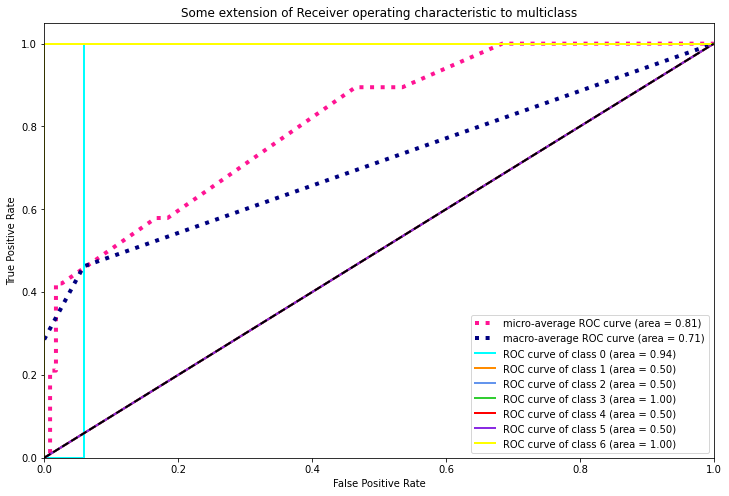

In [21]:
#reference:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# Binarize the output
mul_y_test_bi = preprocessing.label_binarize(mul_y_test,classes=[1,2,3,4,5,6,7])
mul_y_train_bi = preprocessing.label_binarize(mul_y_train,classes=[1,2,3,4,5,6,7])
n_classes = mul_y_test_bi.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    LogisticRegressionCV(Cs=100, cv=3, penalty='l1', solver='saga',random_state=13, n_jobs=-1, max_iter=10000)
)

y_score = classifier.fit(mul_X_train, mul_y_train_bi).decision_function(mul_X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mul_y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mul_y_test_bi.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue","limegreen", "red", "blueviolet","yellow"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

#### 2(c)ii Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

- Gaussian did so much better than Multinomial on this problem

In [22]:
#GaussianNB
max_gnb_score = -1
best_gnb_l = -1
for l in range(1,21):
    features = []
    for i in range(l):
            features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i]
    
    X_train, y_train = df_train_list[l-1][features], mul_label_train
    X_test, y_test = df_test_list[l-1][features], mul_label_test
    GNB = GaussianNB().fit(X_train, y_train)
    score = GNB.score(X_test,y_test)
    #print(score)
    if score > max_gnb_score:
        max_gnb_score = score
        best_gnb_l = l
        
print('best l for GaussianNB:', best_gnb_l)
print('test accuracy:', max_gnb_score)

best l for GaussianNB: 1
test accuracy: 0.9473684210526315


In [23]:
gnb_l = 1
gnb_features = [3, 6, 7, 10, 13, 14, 38, 41, 42]
gnb_X_train, gnb_y_train = df_train_list[l-1][features], mul_label_train
gnb_X_test, gnb_y_test = df_test_list[l-1][features], mul_label_test
best_GNB = GaussianNB().fit(gnb_X_train, gnb_y_train)
gnb_preds_test = best_GNB.predict(gnb_X_test)
gnb_CM = metrics.confusion_matrix(gnb_y_test, gnb_preds_test)
print('GNB Confusion Matrix when l = 1:')
print(gnb_CM)

GNB Confusion Matrix when l = 1:
[[2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 1 1 0]
 [0 0 0 0 0 0 3]]


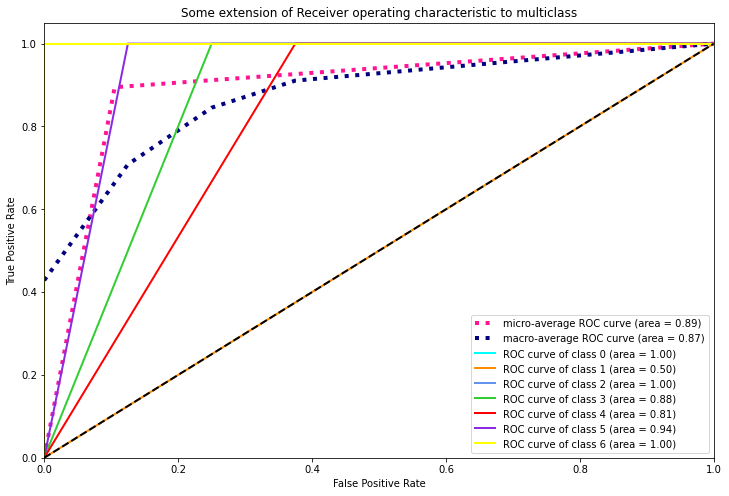

In [24]:
#reference:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# Binarize the output
gnb_y_test_bi = preprocessing.label_binarize(mul_y_test,classes=[1,2,3,4,5,6,7])
gnb_y_train_bi = preprocessing.label_binarize(mul_y_train,classes=[1,2,3,4,5,6,7])
n_classes = gnb_y_test_bi.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(GaussianNB())

y_score = classifier.fit(gnb_X_train, gnb_y_train_bi).predict(gnb_X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mul_y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mul_y_test_bi.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue","limegreen", "red", "blueviolet","yellow"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [25]:
#MultinomialNB
max_mnb_score = -1
best_mnb_l = -1
for l in range(1,21):
    features = []
    for i in range(l):
            features += [3+42*i, 6+42*i, 7+42*i, 10+42*i, 13+42*i, 14+42*i, 38+42*i, 41+42*i, 42+42*i]
    
    X_train, y_train = df_train_list[l-1][features], mul_label_train
    X_test, y_test = df_test_list[l-1][features], mul_label_test
    MNB = MultinomialNB().fit(X_train, y_train)
    score = MNB.score(X_test,y_test)
    #print(score)
    if score > max_mnb_score:
        max_mnb_score = score
        best_mnb_l = l
        
print('best l for MultinomialNB:', best_mnb_l)
print('test accuracy:', max_mnb_score)
print('Actually scores remain the same while l changes')

best l for MultinomialNB: 1
test accuracy: 0.15789473684210525
Actually scores remain the same while l changes


In [26]:
mnb_l = 1
mnb_features = [3, 6, 7, 10, 13, 14, 38, 41, 42]
mnb_X_train, mnb_y_train = df_train_list[l-1][features], mul_label_train
mnb_X_test, mnb_y_test = df_test_list[l-1][features], mul_label_test
best_MNB = MultinomialNB().fit(mnb_X_train, mnb_y_train)
mnb_preds_test = best_MNB.predict(mnb_X_test)
mnb_CM = metrics.confusion_matrix(mnb_y_test, mnb_preds_test)
print('MNB Confusion Matrix when l = 1:')
print(mnb_CM)

MNB Confusion Matrix when l = 1:
[[0 0 0 2 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]]


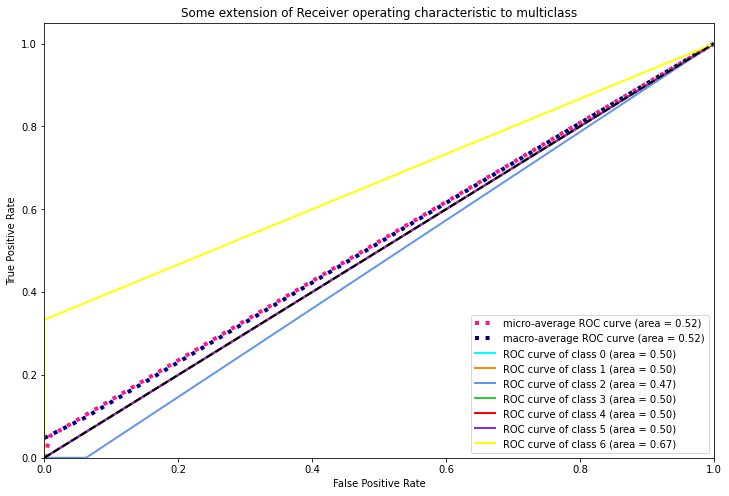

In [27]:
#reference:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# Binarize the output
mnb_y_test_bi = preprocessing.label_binarize(mul_y_test,classes=[1,2,3,4,5,6,7])
mnb_y_train_bi = preprocessing.label_binarize(mul_y_train,classes=[1,2,3,4,5,6,7])
n_classes = mnb_y_test_bi.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(MultinomialNB())

y_score = classifier.fit(mnb_X_train, mnb_y_train_bi).predict(mnb_X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mul_y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mul_y_test_bi.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue","limegreen", "red", "blueviolet","yellow"]
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

#### 2(c)iii Which method is better for multi-class classification in this problem?
- Gaussian NB has a higher average accuracy on each class while L1-penalized did well on classifying certain classes(accuracy = 1 for some classes, but others goes to 0.50).
- overall Gaussian is better.

#### 3 ISLR 4.8.3: This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class- specific mean vector and a class specific covariance matrix. We con- sider the simple case where p = 1; i.e. there is only one feature. Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal dis- tribution. Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

If not displayed please refer to 'sol' folder.
<img src='../sol/islr4.8.3.jpg'/>

#### 4 ISLR 4.8.7:Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X ̄ = 10, while the mean for those that didn’t was X ̄ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

If not displayed please refer to 'sol' folder.
<img src='../sol/islr4.8.7.jpg'/>
